<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
import jax
import jax.numpy as np
from jax import jit, grad, random
from jax.experimental import stax, optimizers
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os, imageio

from IPython.display import clear_output

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(0)

In [2]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())

4
True


## Set up data

In [3]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [[x_test, img]]
train_data = [[x_test[::2,::2], img[::2,::2]]]

# Model and training code

Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

In [4]:
# Fourier feature mapping
def input_mapping(x, B): 
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

'''
# JAX network definition
def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(3))
    layers.append(stax.Sigmoid)
    return stax.serial(*layers)
'''
# PyTorch network definition
class fourier_feature_network(nn.Module):
    def __init__(self, num_layers, num_channels, in_channels):
        # input_size is tensor.numel() or numpy.size
        
        super(fourier_feature_network, self).__init__()
        
        self.initial_dense_layer = nn.Linear(in_channels, num_channels)
        hidden_dense_layers = []
        for layer_idx in range(num_layers - 2):
            curr_layer = nn.Linear(num_channels, num_channels)
            hidden_dense_layers.append(curr_layer)
            
        self.hidden_dense_layers = nn.ModuleList(hidden_dense_layers)
            
        self.final_dense_layer = nn.Linear(num_channels, 3)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.initial_dense_layer(x)
        for layer_idx, curr_dense_layer in enumerate(self.hidden_dense_layers):
            x = curr_dense_layer(x)
            x = self.relu(x)
            
        x = self.final_dense_layer(x)
        x = self.sigmoid(x)
        
        return x

class fourier_feature_dataset(torch.utils.data.Dataset):
    def __init__(self, data, B):
        self.x = [curr_data[0] for curr_data in train_data]
        self.y = [curr_data[1] for curr_data in train_data]
        self.B = B

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        fourier_features = torch.from_numpy(input_mapping(self.x[idx], self.B))
        out_image = torch.from_numpy(self.y[idx])
        
        return fourier_features, out_image
    
def custom_loss(x, y):
    return 0.5 * nn.MSELoss()(x.float(), y.float())
        
def calculate_PSNR(loss):
    # jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
    return -10 * np.log10(loss.detach().cpu().numpy() * 2)
        
def train_model(network_size, learning_rate, iters, B, train_data, test_data):
    
    train_dataset = fourier_feature_dataset(train_data, B)
    test_dataset = fourier_feature_dataset(test_data, B)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    fourier_model = fourier_feature_network(network_size[0], network_size[1], train_dataset[0][0].shape[-1])
    fourier_model = fourier_model.float()
    
    # GPU handling
    # https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        fourier_model = nn.DataParallel(fourier_model)
    fourier_model = fourier_model.to(device).cuda()
    
    optimizer = optim.Adam(fourier_model.parameters(), lr=learning_rate)
    
    x_vals = []
    train_psnrs = []
    test_psnrs = []
    prediction_images = []
    
    # print(model.module1.fc1.weight.type())
    
    for epoch in range(iters):
        for idx, data in enumerate(train_loader):
            fourier_features, labels = data

            optimizer.zero_grad()

            fourier_features = fourier_features.float()
            fourier_features = fourier_features.to(device).cuda() # For gpu
            labels = labels.to(device).cuda()
            
            model_outputs = fourier_model(fourier_features)
            loss = custom_loss(model_outputs, labels)
            loss.backward()
            optimizer.step()

        # if epoch % 25 == 0:

        clear_output(wait=True)
        print(str(epoch) + '/' + str(iters))

        train_psnrs.append(calculate_PSNR(loss))

        test_loss = 0
        for test_idx, test_data in enumerate(test_loader):
            test_features, test_labels = test_data
            
            test_features = test_features.float()
            test_features = test_features.to(device).cuda()
            test_labels = test_labels.to(device).cuda()
            
            test_loss += custom_loss(fourier_model(test_features), test_labels)
        test_loss /= len(test_loader)

        test_psnrs.append(calculate_PSNR(test_loss))
        # prediction_images.append(fourier_model(test_dataset[0][0].float()))
        x_vals.append(epoch)
                
    prediction_images.append(fourier_model(test_dataset[0][0].float()))
            
    return {
        'state': fourier_model.state_dict(),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': prediction_images,
        'xs': x_vals
    }
    
'''
# Train model with given hyperparameters and data
def train_model(network_size, learning_rate, iters, B, train_data, test_data):
    
    init_fn, apply_fn = make_network(*network_size)

    model_pred = jit(lambda params, x: apply_fn(params, input_mapping(x, B)))
    model_loss = jit(lambda params, x, y: .5 * np.mean((model_pred(params, x) - y) ** 2))
    model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
    model_grad_loss = jit(lambda params, x, y: jax.grad(model_loss)(params, x, y))

    opt_init, opt_update, get_params = optimizers.adam(learning_rate)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, input_mapping(train_data[0], B).shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    pred_imgs = []
    xs = []
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)

        if i % 25 == 0:
            train_psnrs.append(model_psnr(get_params(opt_state), *train_data))
            test_psnrs.append(model_psnr(get_params(opt_state), *test_data))
            pred_imgs.append(model_pred(get_params(opt_state), test_data[0]))
            xs.append(i)
    
    return {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs' : np.stack(pred_imgs),
        'xs': xs,
    }
'''

"\n# Train model with given hyperparameters and data\ndef train_model(network_size, learning_rate, iters, B, train_data, test_data):\n    \n    init_fn, apply_fn = make_network(*network_size)\n\n    model_pred = jit(lambda params, x: apply_fn(params, input_mapping(x, B)))\n    model_loss = jit(lambda params, x, y: .5 * np.mean((model_pred(params, x) - y) ** 2))\n    model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))\n    model_grad_loss = jit(lambda params, x, y: jax.grad(model_loss)(params, x, y))\n\n    opt_init, opt_update, get_params = optimizers.adam(learning_rate)\n    opt_update = jit(opt_update)\n\n    _, params = init_fn(rand_key, (-1, input_mapping(train_data[0], B).shape[-1]))\n    opt_state = opt_init(params)\n\n    train_psnrs = []\n    test_psnrs = []\n    pred_imgs = []\n    xs = []\n    for i in tqdm(range(iters), desc='train iter', leave=False):\n        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_s

## Train networks with different input mappings

We compare the following mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

<!-- - Positional encoding: $\gamma(\mathbf{v})=\left[ \ldots, \cos(2 \pi \sigma^{j/m} \mathbf{v}),\sin(2 \pi \sigma^{j/m} \mathbf{v}), \ldots \right]^\mathrm{T}$ for $j = 0, \ldots, m-1$.  -->

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$


In [8]:
# network_size = (4, 256)
network_size = (4, 512)
# Changing both the mapping size and network_size to 512 doesn't set the output to 512

learning_rate = 1e-4
# iters = 2000
iters = 1

# mapping_size = 256
mapping_size = 512
# Simply changing the mapping size to 512 doesn't set the output to 512

B_dict = {}
# Standard network - no mapping
B_dict['none'] = None
# Basic mapping
B_dict['basic'] = np.eye(2)
# Three different scales of Gaussian Fourier feature mappings
B_gauss = np.random.normal(loc=0, scale=1, size=(mapping_size, 2))
for scale in [1., 10., 100.]:
  B_dict[f'gauss_{scale}'] = B_gauss * scale

# This should take about 2-3 minutes
outputs = {}
for k in tqdm(B_dict):
  outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)

0/1



In [9]:
for i, k in enumerate(outputs):
    print(outputs[k]['pred_imgs'][-1].cpu().detach().numpy().shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


## Plot results

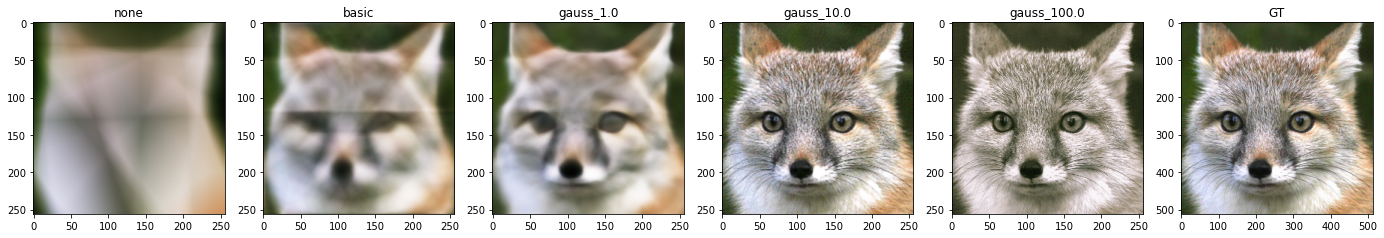

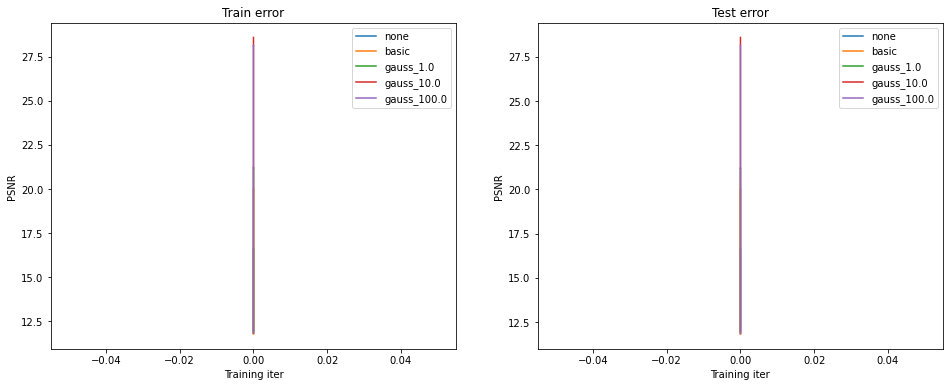

In [94]:
# Show final network outputs

plt.figure(figsize=(24,4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1,N+1,i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1].cpu().detach().numpy())
    plt.title(k)
plt.subplot(1,N+1,N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16,6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

In [ ]:
if False:
    # Save out video
    all_preds = np.concatenate([outputs[n]['pred_imgs'] for n in outputs], axis=-2)
    data8 = (255*np.clip(all_preds,0,1)).astype(np.uint8)
    f = os.path.join('training_convergence.mp4')
    imageio.mimwrite(f, data8, fps=20)

    # Display video inline
    from IPython.display import HTML
    from base64 import b64encode
    mp4 = open(f,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    HTML(f'''
    <video width=1000 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    <table width="1000" cellspacing="0" cellpadding="0">
      <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
      <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
    </table>
    '''.format(*list(outputs.keys())))